In [1]:
%load_ext nb_black
%load_ext autotime

<IPython.core.display.Javascript object>

time: 15 ms (started: 2021-09-09 11:33:20 +02:00)


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt

from sklearn import set_config

set_config(display="diagram")
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import TransformerMixin, BaseEstimator

from itertools import combinations

from sklearn.decomposition import PCA

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
)

from joblib import dump, load

from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth

from sklearn.metrics import (
    davies_bouldin_score,
    adjusted_rand_score,
    silhouette_score,
    silhouette_samples,
)

from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = 100
sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [8]:
# ouverture du dataframe
df_fraud = pd.read_csv(r'C:\\Users\\alojou\\Notebook Python\\Projet_7 Modèle de scoring\\Data\\df_clean.csv')
df_fraud = df_fraud.loc[:,~df_fraud.columns.str.startswith('Unnamed')]

In [13]:
category_features = []
threshold = 10
for each in df_fraud.columns:
    if df_fraud[each].nunique() < threshold:
        category_features.append(each)

print("transformed from numerical to categorical : ",category_features)   
        
        
for each in category_features:
    df_fraud[each] = df_fraud[each].astype('category')

obj_col = df_fraud.select_dtypes("object").columns
for each in obj_col:
    df_fraud[each] = df_fraud[each].astype('category')

transformed from numerical to categorical :  ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DO

In [14]:
df_fraud.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMIN_MODE,LANDAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,NONLIVINGAPARTMENTS_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,1,1,0,Laborers,2,2,WEDNESDAY,0,0,0,0,0,0,Business,reg oper account,block of flats,"Stone, brick",No,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,202500.0,406597.5,0.018801,-9461.0,-637.0,-3648.0,-2120.0,19.471084,10.0,0.083037,0.262949,0.139376,0.024700,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.036900,0.000000,0.000000,0.025200,0.038300,0.634100,0.014400,0.000000,0.069000,0.125000,0.037700,0.000000,0.000000,0.000000,2.0,2.0,-1134.0,0.000000,0.000000,1.000000
1,0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,1,1,0,1,1,0,Core staff,1,1,MONDAY,0,0,0,0,0,0,School,reg oper account,block of flats,Block,No,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,270000.0,1293502.5,0.003541,-16765.0,-1188.0,-1186.0,-291.0,16.577012,11.0,0.311267,0.622246,0.452989,0.095900,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.013000,0.003900,0.009800,0.092400,0.053800,0.804000,0.049700,0.080600,0.034500,0.333300,0.012800,0.000000,0.000000,0.003900,1.0,0.0,-828.0,0.000000,0.000000,0.000000
2,0,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,1,1,1,0,Laborers,2,2,MONDAY,0,0,0,0,0,0,Government,NaN,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,67500.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,26.000000,9.0,0.603147,0.555912,0.729567,0.117404,0.088099,0.977674,0.751425,0.044379,0.077894,0.149589,0.066650,0.008733,0.028014,0.114442,0.088087,0.760971,0.044081,0.075204,0.145017,0.229976,0.064867,0.008378,0.027285,0.008605,0.0,0.0,-815.0,0.000000,0.000000,0.000000
3,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,1,1,0,1,0,0,Laborers,2,2,WEDNESDAY,0,0,0,0,0,0,Business,NaN,NaN,NaN,NaN,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0.0,135000.0,312682.5,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,11.712677,17.0,0.654130,0.650442,0.545973,0.117423,0.088046,0.977676,0.751302,0.044223,0.078178,0.149817,0.066584,0.008606,0.027801,0.114418,0.088365,0.760869,0.044107,0.075114,0.145028,0.230100,0.064991,0.00

In [15]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 95 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  category
 1   NAME_CONTRACT_TYPE           307511 non-null  category
 2   CODE_GENDER                  307511 non-null  category
 3   FLAG_OWN_CAR                 307511 non-null  category
 4   FLAG_OWN_REALTY              307511 non-null  category
 5   NAME_TYPE_SUITE              306219 non-null  category
 6   NAME_INCOME_TYPE             307511 non-null  category
 7   NAME_EDUCATION_TYPE          307511 non-null  category
 8   NAME_FAMILY_STATUS           307511 non-null  category
 9   NAME_HOUSING_TYPE            307511 non-null  category
 10  FLAG_MOBIL                   307511 non-null  category
 11  FLAG_EMP_PHONE               307511 non-null  category
 12  FLAG_WORK_PHONE              307511 non-null

### Gestion des imbalance data

In [24]:
data = df_fraud.drop(['TARGET'], axis = 1)
target = df_fraud[['TARGET']]

In [30]:
# definition des transformers

ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
ss = MinMaxScaler()
pca = PCA(n_components="mle")


# definition des groupes de feature qui vont subir les même transformation
cat_vars = data.select_dtypes("category").columns
num_vars = data.select_dtypes(include=np.number).columns


# Creation des pipeline de transformation
categorical_pipe = Pipeline([("ohe", ohe), ("ss", ss)])
numeric_pipe = Pipeline([("ss", ss)])


# Creation des columnTransformer
col_transformer = ColumnTransformer(
    transformers=[
        ("nums", numeric_pipe, num_vars),
        ("cats", categorical_pipe, cat_vars),
    ],
    remainder="drop",
    n_jobs=None,
)
# creation de différent pipe pour trouver la meilleur combinaison
data_pipe = Pipeline([("col_transformer", col_transformer)])
#, ("pca", pca)

In [32]:
data = data_pipe.fit_transform(data)

In [34]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data,target, test_size=0.33, random_state = 42)


In [35]:
y_train.value_counts(normalize=True)

TARGET
0         0.918906
1         0.081094
dtype: float64

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(x_train,y_train)

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
y_test_pred = clf.predict(x_test)

In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[93304,    58],
       [ 8045,    72]], dtype=int64)

In [57]:
clf = LogisticRegression(class_weight = 'balanced').fit(x_train,y_train)

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
y_test_pred = clf.predict(x_test)

In [59]:
confusion_matrix(y_test, y_test_pred)

array([[64139, 29223],
       [ 2618,  5499]], dtype=int64)

In [66]:
len(np.unique(y_train))

2

In [70]:
from sklearn.utils import class_weight
class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

c:\users\alojou\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=       TARGET
290720      0
219406      0
238458      0
189443      0
32184       0
...       ...
119879      0
259178      0
131932      0
146867      0
121958      1

[206032 rows x 1 columns] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: classes should include all valid labels that can be in y

In [71]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     93362
           1       0.16      0.68      0.26      8117

    accuracy                           0.69    101479
   macro avg       0.56      0.68      0.53    101479
weighted avg       0.90      0.69      0.76    101479



### Generation des Pipe 

In [10]:
X_train.select_dtypes(include=np.number).columns.values

array(['delivery_duration_day_mean', 'nb_order',
       'answer_duration_in_hours_per_order_mean',
       'nb_comment_mean_per_order', 'review_score_mean_per_order',
       'nb_item_mean_per_product_per_order',
       'freight_mean_value_per_order', 'product_volume_mean',
       'price_home', 'price_electronics', 'price_health_beauty',
       'price_sports_leisure', 'price_appliances', 'price_fashion',
       'price_garden_pets', 'price_arts', 'price_office', 'price_auto',
       'price_other', 'price_construction', 'price_food_drinks',
       'nb_payment_different_per_order', 'nb_time_payment_per_order',
       'type credit_card', 'type boleto', 'type voucher',
       'type debit_card', 'frequency_as_day'], dtype=object)

<IPython.core.display.Javascript object>

time: 47 ms (started: 2021-09-09 11:33:39 +02:00)


### Modelisation Kmeans

la repartition des différent client dans les cluster : {0: 3839, 1: 27640, 2: 4683, 3: 328, 4: 76, 5: 2998, 6: 37974, 7: 66, 8: 5074, 9: 10679}
davies_bouldin_score 2.9742258090183835
Silhouette_score 0.10298999
For n_clusters = 10 The average silhouette_score is : 0.10298999


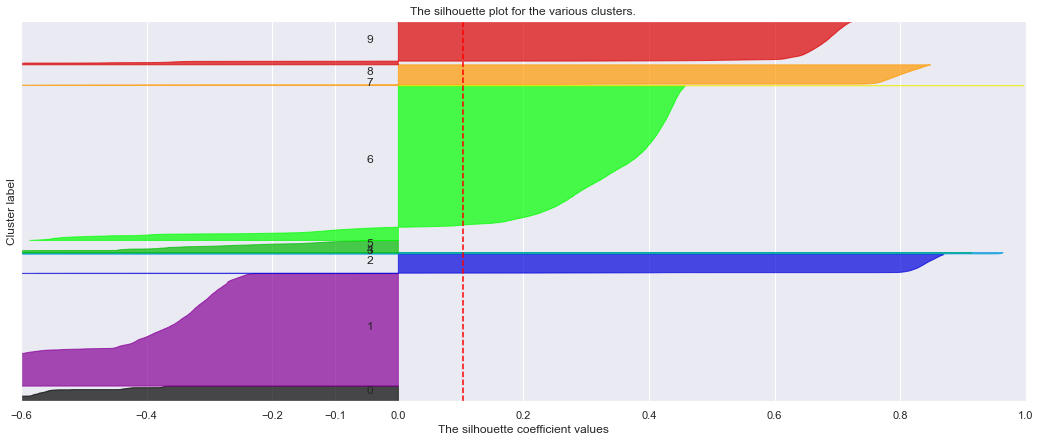

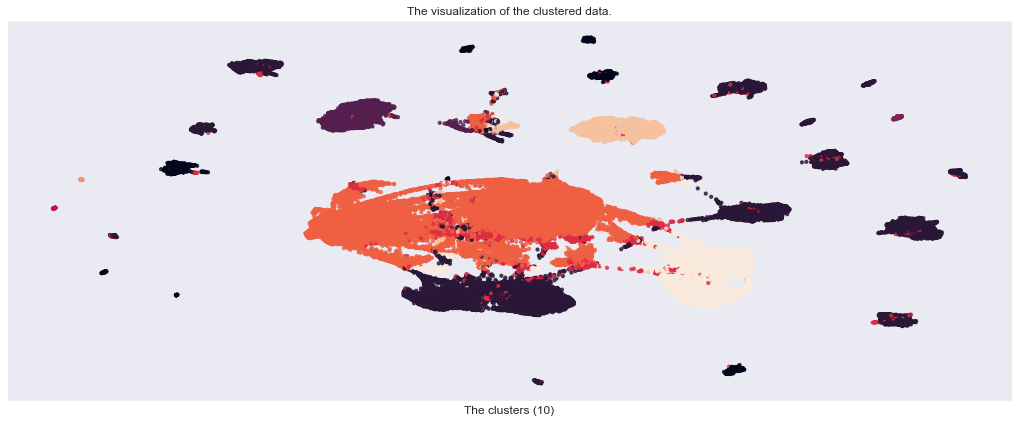

la repartition des différent client dans les cluster : {0: 3792, 1: 27230, 2: 4615, 3: 328, 4: 76, 5: 2800, 6: 37324, 7: 66, 8: 4988, 9: 10500, 10: 1638}
davies_bouldin_score 3.028234188198318
Silhouette_score 0.10848417
For n_clusters = 11 The average silhouette_score is : 0.10848417


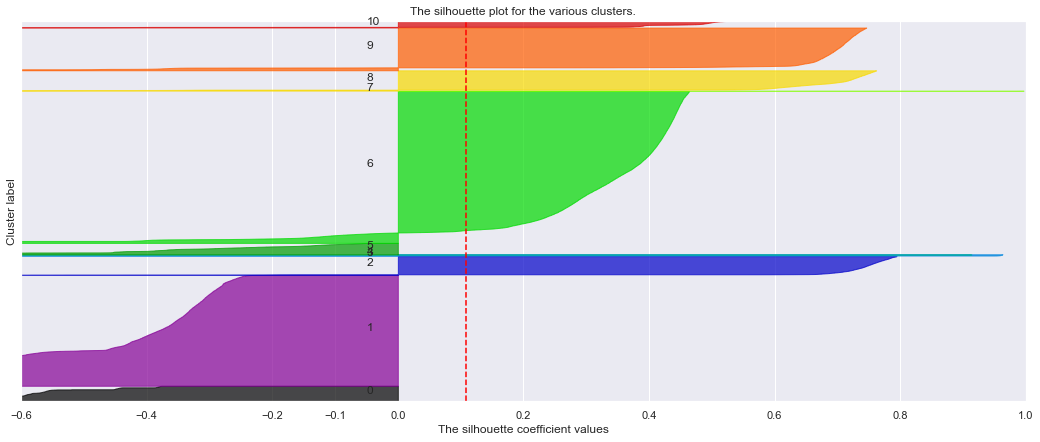

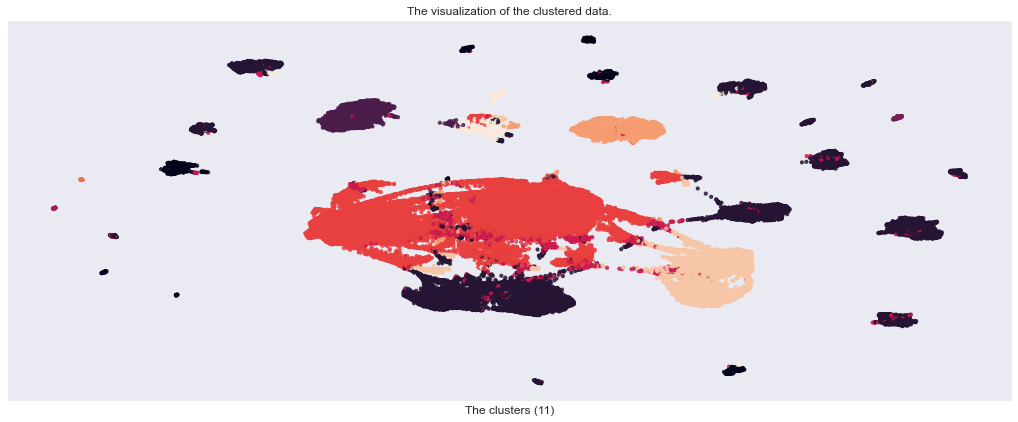

la repartition des différent client dans les cluster : {0: 3808, 1: 25502, 2: 4631, 3: 328, 4: 76, 5: 2671, 6: 37531, 7: 66, 8: 5013, 9: 10557, 10: 1979, 11: 1195}
davies_bouldin_score 3.175977069858219
Silhouette_score 0.10788837
For n_clusters = 12 The average silhouette_score is : 0.10788837


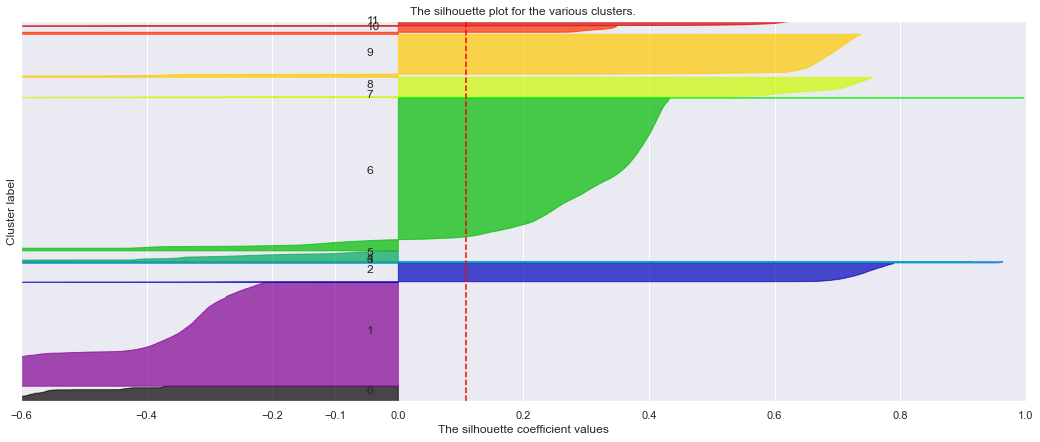

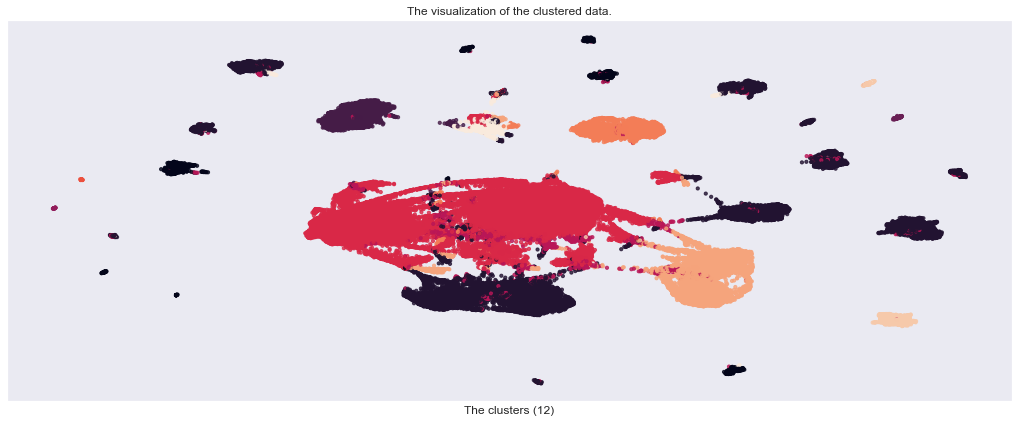

la repartition des différent client dans les cluster : {0: 16518, 1: 38206, 2: 4697, 3: 1906, 4: 1532, 5: 267, 6: 1868, 7: 1573, 8: 3122, 9: 11679, 10: 854, 11: 328, 12: 10807}
davies_bouldin_score 1.2465451182610252
Silhouette_score 0.28539732
For n_clusters = 13 The average silhouette_score is : 0.28539732


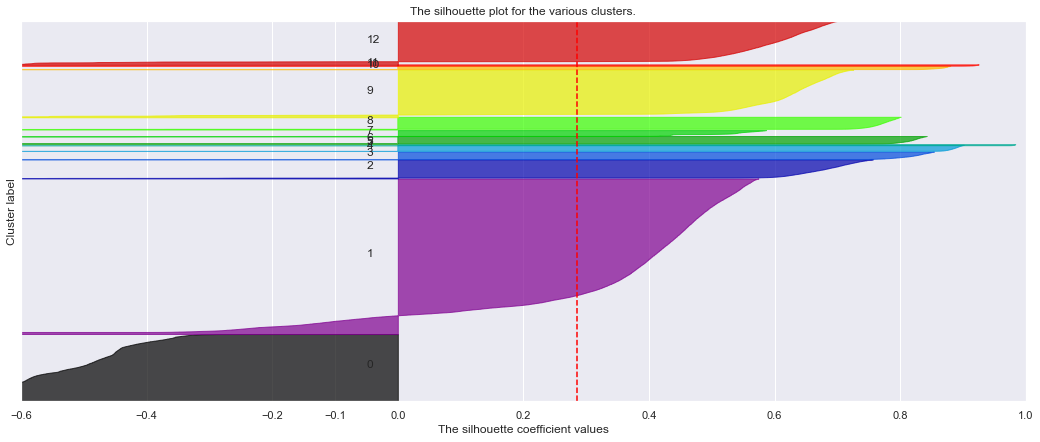

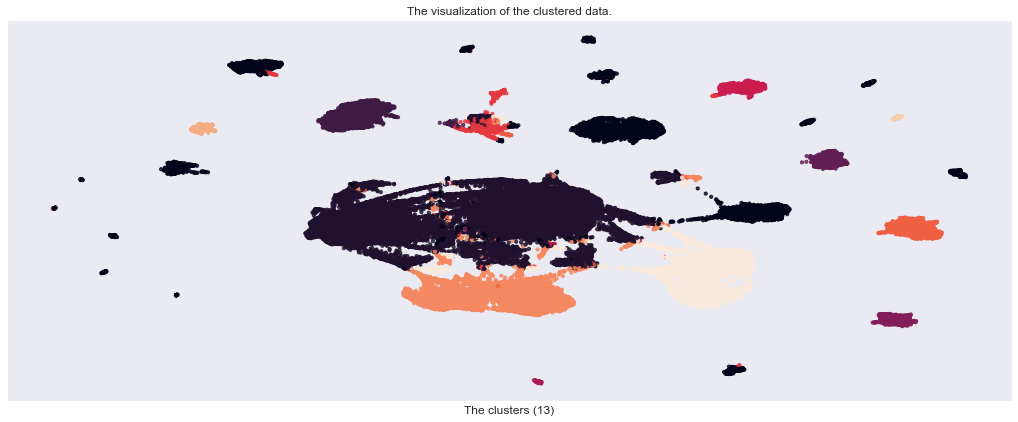

la repartition des différent client dans les cluster : {0: 15679, 1: 37456, 2: 4615, 3: 1891, 4: 1520, 5: 267, 6: 1849, 7: 2406, 8: 3060, 9: 11363, 10: 851, 11: 328, 12: 10520, 13: 1552}
davies_bouldin_score 1.740352804405998
Silhouette_score 0.25782698
For n_clusters = 14 The average silhouette_score is : 0.25782698


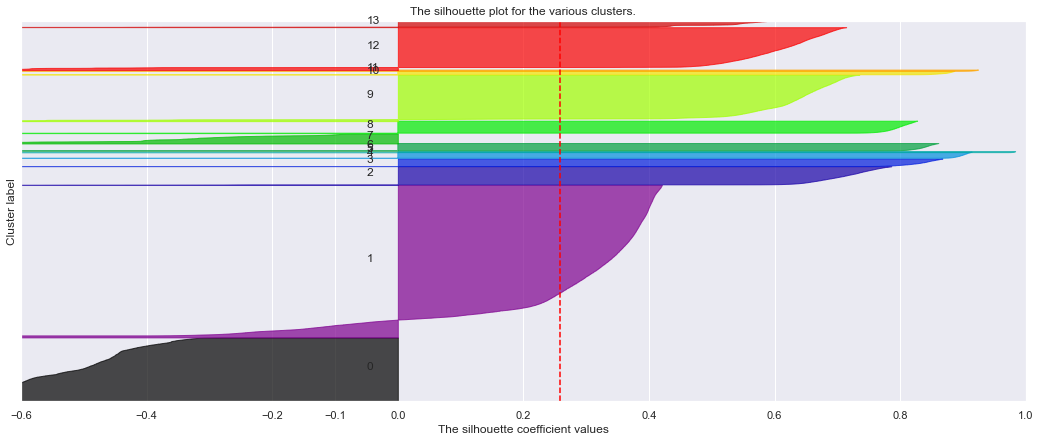

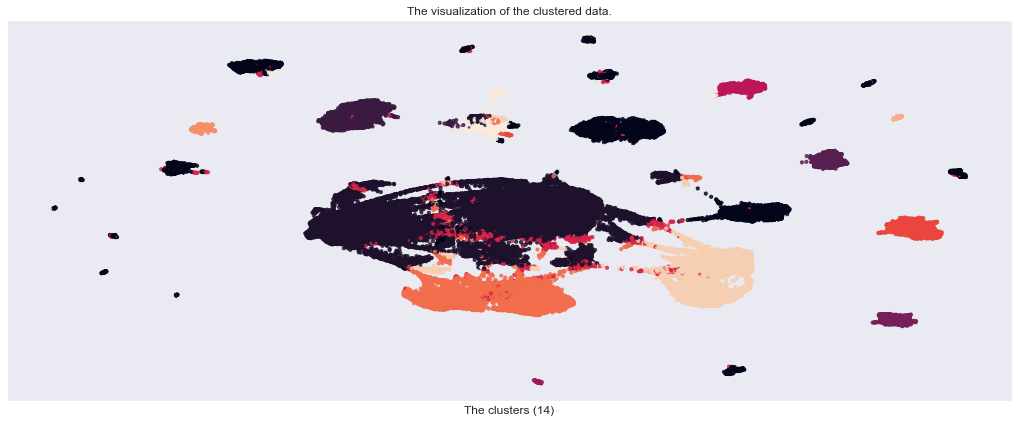

la repartition des différent client dans les cluster : {0: 13481, 1: 11887, 2: 38909, 3: 5164, 4: 463, 5: 851, 6: 140, 7: 66, 8: 4758, 9: 10980, 10: 1542, 11: 1891, 12: 698, 13: 464, 14: 140, 15: 1923}
davies_bouldin_score 1.5355791345885943
Silhouette_score 0.23967554
For n_clusters = 16 The average silhouette_score is : 0.23967554


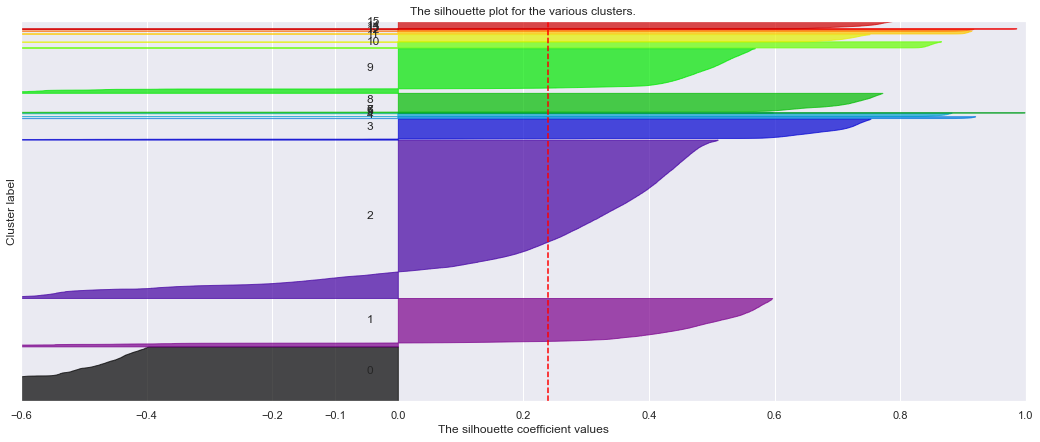

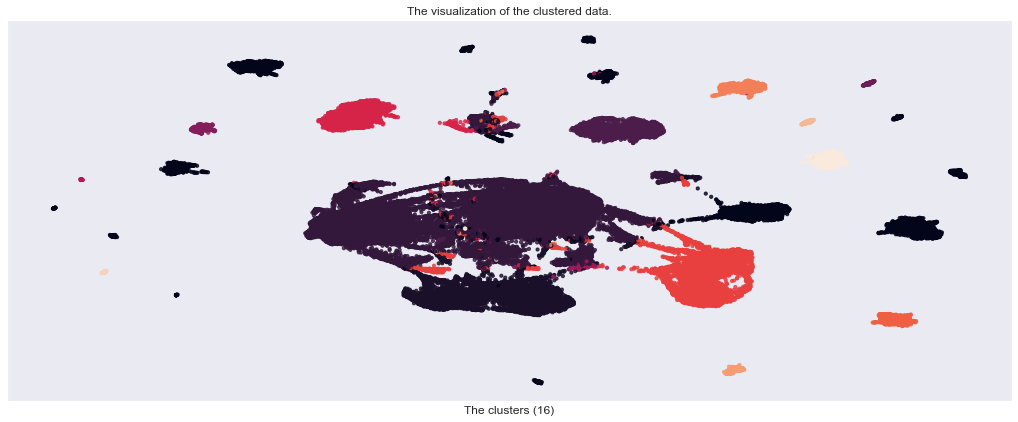

<IPython.core.display.Javascript object>

time: 1h 44min 57s (started: 2021-09-18 09:36:49 +02:00)


In [22]:
# transformation de notre dataframe
X_trans = data_pipe_umap.fit_transform(X_train)

# creation des test pour kmean
test_cluster = np.linspace(10, 16, 6, dtype="int")

# initialisation du dictionnaire de resultat

dict_result = {
    "n_clusters": [],
    "Silhouette_AVG": [],
    "Score_davies_bouldin": [],
    "Silhouette_score": [],
}

# preparation à la modelisation
for n_clusters in test_cluster:
    dict_result["n_clusters"].append(n_clusters)

    pipe = Pipeline(
        [
            ("data_pipe", data_pipe_pca),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=42)),
        ]
    )
    # prediction des labels pour chaque client
    labels = pipe.fit_predict(X_train)

    # repartition des cluster
    unique, counts = np.unique(labels, return_counts=True)
    cluster_repartition = dict(zip(unique, counts))

    print("la repartition des différent client dans les cluster :", cluster_repartition)

    # scoring
    Davies_bouldin_score = davies_bouldin_score(X_trans, labels)

    dict_result["Score_davies_bouldin"].append(Davies_bouldin_score)

    print("davies_bouldin_score", Davies_bouldin_score)

    Silhouette_score = silhouette_score(X_trans, labels)

    dict_result["Silhouette_score"].append(Silhouette_score)

    print("Silhouette_score", Silhouette_score)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_trans) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_trans, labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    dict_result["Silhouette_AVG"].append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_trans, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6, -0.4, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    fig2, (ax2) = plt.subplots(1, 1)
    fig2.set_size_inches(18, 7)
    ax2.scatter(
        X_trans[:, 0], X_trans[:, 1], c=labels, edgecolor=None, alpha=0.80, s=10
    )
    ax2.set_yticks([])
    ax2.set_xticks([])

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("The clusters ({})".format(n_clusters))
    plt.show()

In [23]:
pd.DataFrame.from_dict(dict_result).sort_values(
    by=["Score_davies_bouldin"], ascending=True
)

,n_clusters,Silhouette_AVG,Score_davies_bouldin,Silhouette_score
3,13,0.285397,1.246545,0.285397
5,16,0.239676,1.535579,0.239676
4,14,0.257827,1.740353,0.257827
0,10,0.102990,2.974226,0.102990
1,11,0.108484,3.028234,0.108484
2,12,0.107888,3.175977,0.107888


<IPython.core.display.Javascript object>

time: 109 ms (started: 2021-09-18 11:21:47 +02:00)
